# EDA
### en este archivo se realiza el analisis exploratorio de los datasets

In [1]:
# importamos las librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

## EDA de Internet firewall data

In [2]:
ifd = pd.read_csv('DataSets/Internet_Firewall_Data.csv')

In [3]:
ifd.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


Observemos la distribucion de los de los ataques (nuestra columna target, Action)

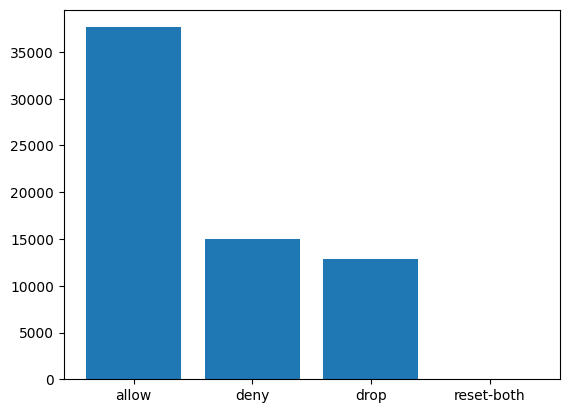

In [4]:
categorias= ifd['Action']
plt.bar(categorias.value_counts().index, categorias.value_counts())
plt.show()

Podemos ver, que tenemos muy pocos datos de reset-both, veamos cuantos son

In [5]:
ifd['Action'].value_counts()

Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: count, dtype: int64

In [6]:
ifd.shape

(65532, 12)

Podemos ver que de los 65532 datos, solo 54 es reset-both, por lo cual, si intentamos usar el modelo para que tome esta acción en específico, probablemente no lo haga bien, ya que no tiene suficientes datos para aprender.

Además, ahora también podemos ver que tenemos 27892 datos de ataques, y 37640 de no ataques, lo cual podría ser un problema, dado que tenemos casí 10 mil datos más de no ataques que de ataques, lo cual podría hacer que el modelo aprenda a clasificar todo como no ataque, y no queremos eso.

Ahora, observemos los puertos

In [7]:
ifd.dtypes

Source Port              int64
Destination Port         int64
NAT Source Port          int64
NAT Destination Port     int64
Action                  object
Bytes                    int64
Bytes Sent               int64
Bytes Received           int64
Packets                  int64
Elapsed Time (sec)       int64
pkts_sent                int64
pkts_received            int64
dtype: object

Podemos ver que aunque son de tipo int, estos no son valores continuos, sino que son categoricos, por lo cual, no tiene sentido hacer un histograma, pero si podemos ver cuantos valores únicos hay

In [8]:
print('Source Port valores numero de valores unicos:', ifd['Source Port'].nunique())
print('Destination Port valores numero de valores unicos:', ifd['Destination Port'].nunique())
print('NAT Source Port valores numero de valores unicos:', ifd['NAT Source Port'].nunique())
print('NAT Destination Port valores numero de valores unicos:', ifd['NAT Destination Port'].nunique())

Source Port valores numero de valores unicos: 22724
Destination Port valores numero de valores unicos: 3273
NAT Source Port valores numero de valores unicos: 29152
NAT Destination Port valores numero de valores unicos: 2533


In [9]:
#Ahora veamos los valores más comunes
print(ifd['Source Port'].value_counts().nlargest(1))
print(ifd['Destination Port'].value_counts().nlargest(1))
print(ifd['NAT Source Port'].value_counts().nlargest(1))
print(ifd['NAT Destination Port'].value_counts().nlargest(1))

Source Port
58638    840
Name: count, dtype: int64
Destination Port
53    15414
Name: count, dtype: int64
NAT Source Port
0    28432
Name: count, dtype: int64
NAT Destination Port
0    28432
Name: count, dtype: int64


Aquí podemos ver algo interesante, en ambos casos para NAT, el puerto más comun es 0, lo cual es raro, ya que el puerto 0 no existe, por lo cual, probablemente sea un valor nulo, lo cual tendremos en cuenta cuando vayamos a limpiar los datos para el modelo.

Ahora, recordemos que nuestra variable target es Action, y esta es una variable categorica, para cualcular la correlación pasaremos los datos a numericos, para esto usaremos el metodo de LabelEncoder

In [10]:
le = LabelEncoder()
ifd['Action'] = le.fit_transform(ifd['Action'])
ifd['Action'].value_counts()

Action
0    37640
1    14987
2    12851
3       54
Name: count, dtype: int64

Ahora podemos ver que 0 es no ataque, y de 1 a 3 son ataques, por lo cual, podemos calcular la correlación

In [11]:
ifd.corrwith(ifd['Action']).abs().sort_values(ascending=False)

Action                  1.000000
NAT Source Port         0.686893
NAT Destination Port    0.214765
Elapsed Time (sec)      0.170684
Destination Port        0.095110
Source Port             0.038343
Bytes Received          0.023794
pkts_received           0.021679
Packets                 0.015562
Bytes                   0.013546
pkts_sent               0.009842
Bytes Sent              0.004570
dtype: float64

Podemos ver algo preocupante, una de las mayores correlaciones es con las columnas NAT, que ya habiamos mencionado que tenian muchos valores nulos, por lo cual, probablemente no sean de mucha ayuda, por lo cual las vamos a borrar.

Dicho esto, podemos ver que source port y destination port tienen una correlación baja, por lo cual las vamos a borrar también para evitar problemas, dado que son columnas categoricas que hasta el momento estamos usando como numericas, lo cual podría causar problemas.

In [12]:
ifd = ifd.drop(columns=['NAT Source Port', 'NAT Destination Port', 'Source Port', 'Destination Port'])
ifd.head()

,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,0,177,94,83,2,30,1,1
1,0,4768,1600,3168,19,17,10,9
2,0,238,118,120,2,1199,1,1
3,0,3327,1438,1889,15,17,8,7
4,0,25358,6778,18580,31,16,13,18


Ahora, busquemos valores atípicos

In [13]:
ifd.describe()

,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,0.623375,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,0.794945,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,0.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,1.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,3.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


Podemos ver que todas las columnas tienen valores atípicos y que la desviación estandar es muy alta, en todos los casos, por lo cual ya sabemos que van a haber valores atípicos, por lo cual, vamos a hacer un boxplot para verlos

Text(0.5, 1.0, 'Box Plot')

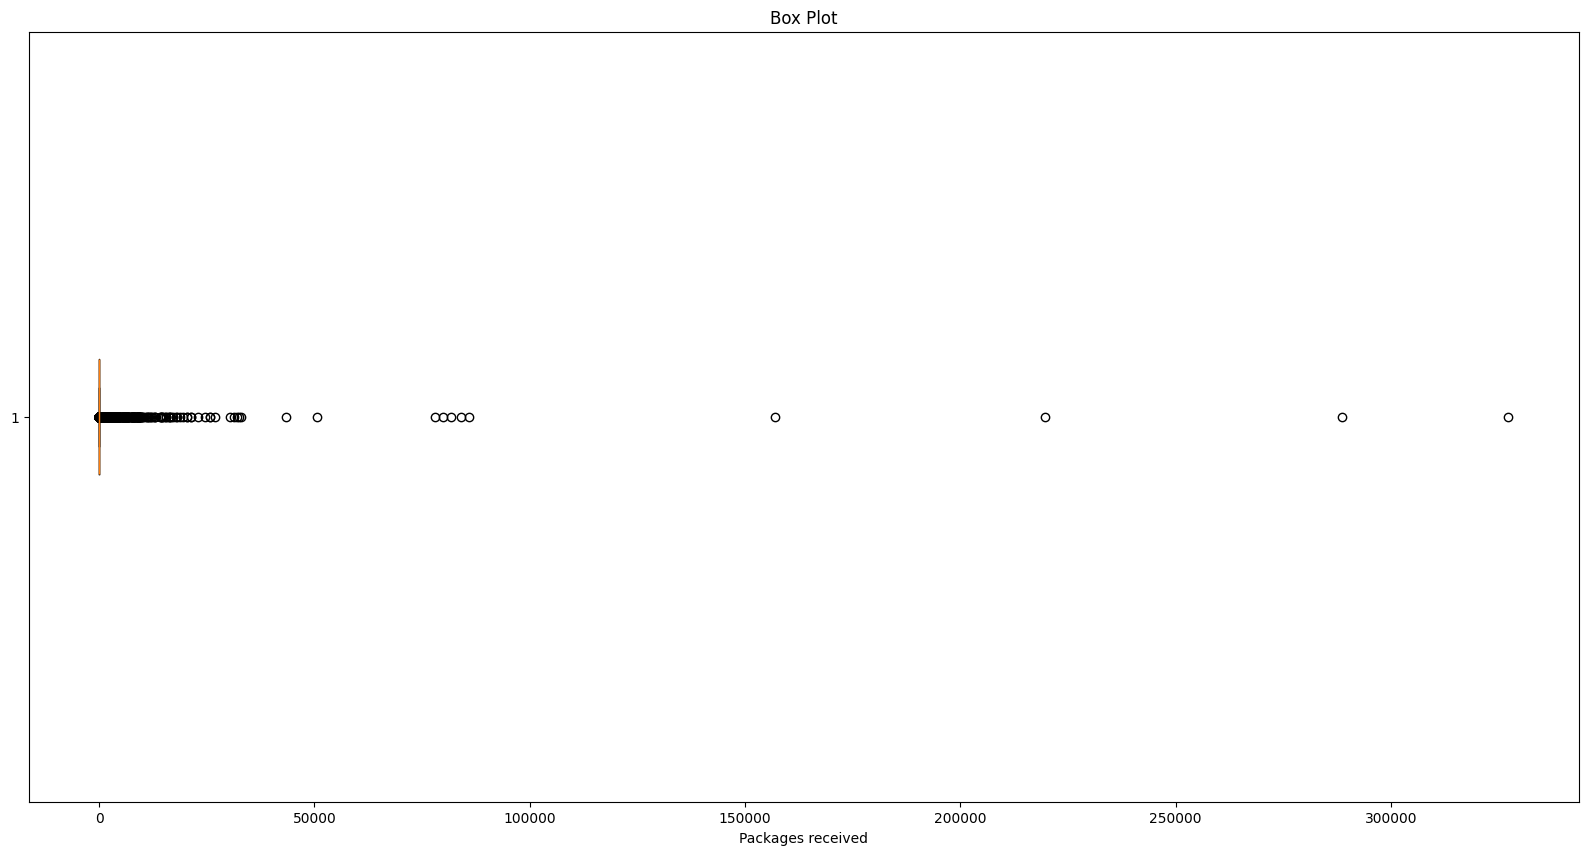

In [14]:
plt.figure(figsize=(20, 10))
plt.boxplot(ifd['pkts_received'],vert=False)
plt.xlabel('Packages received')
plt.title('Box Plot')

Dado que apenas se puede ver, y que tenemos muchos, vamos a calcular cuantos valores atipicos tenemos

In [15]:
#dado que haremos esto varias veces, vamos a hacer una funcion

def datos_atipicos(df,column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)

    # sacamos el rango intercuartil
    limite_inferior = q1
    limite_superior = q3

    # contamos el numero de datos atipicos
    num_atypical_q1 = (df[column] < limite_inferior).sum()
    num_atypical_q3 = (df[column] > limite_superior).sum()
    num_atypical = num_atypical_q1 + num_atypical_q3
    
    print("Datos atipicos en:", column)
    print("Cantidad de datos atipicos en", column, "inferior:", num_atypical_q1)
    print("Cantidad de datos atipicos en", column, "superior:", num_atypical_q3)
    print("Cantidad de datos atipicos en", column, ":", num_atypical)
    print("Porcentaje de datos atipicos en", column, ":", num_atypical / df.shape[0] * 100, "% \n")



In [16]:
datos_atipicos(ifd,'pkts_received')
datos_atipicos(ifd,'pkts_sent')
datos_atipicos(ifd,'Bytes Received')
datos_atipicos(ifd,'Bytes Sent')
datos_atipicos(ifd,'Elapsed Time (sec)')

Datos atipicos en: pkts_received
Cantidad de datos atipicos en pkts_received inferior: 0
Cantidad de datos atipicos en pkts_received superior: 15916
Cantidad de datos atipicos en pkts_received : 15916
Porcentaje de datos atipicos en pkts_received : 24.287371055362268 % 

Datos atipicos en: pkts_sent
Cantidad de datos atipicos en pkts_sent inferior: 0
Cantidad de datos atipicos en pkts_sent superior: 15924
Cantidad de datos atipicos en pkts_sent : 15924
Porcentaje de datos atipicos en pkts_sent : 24.299578831715802 % 

Datos atipicos en: Bytes Received
Cantidad de datos atipicos en Bytes Received inferior: 0
Cantidad de datos atipicos en Bytes Received superior: 16356
Cantidad de datos atipicos en Bytes Received : 16356
Porcentaje de datos atipicos en Bytes Received : 24.958798754806814 % 

Datos atipicos en: Bytes Sent
Cantidad de datos atipicos en Bytes Sent inferior: 7452
Cantidad de datos atipicos en Bytes Sent superior: 16377
Cantidad de datos atipicos en Bytes Sent : 23829
Porcent

Dado que tenemos muchos valores atipicos, vamos a borrarlos, para esto vamos a usar el rango intercuartil, que es la diferencia entre el tercer y primer cuartil, y vamos a borrar los datos que esten por fuera de este rango

Una vez hecho esto vamos a revisar la correlación de nuevo

In [17]:
#dado que haremos esto varias veces, vamos a hacer una funcion
def borrar_atipicos(df,column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)

    # sacamos el rango intercuartil
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    # borramos los datos atipicos
    df = df[(df[column] > limite_inferior) & (df[column] < limite_superior)]
    return df

Datos antes de borrar atipicos

In [18]:
ifd.corrwith(ifd['Action']).sort_values(ascending=False)

Action                1.000000
Bytes Sent           -0.004570
pkts_sent            -0.009842
Bytes                -0.013546
Packets              -0.015562
pkts_received        -0.021679
Bytes Received       -0.023794
Elapsed Time (sec)   -0.170684
dtype: float64

In [19]:
ifd_limpio = borrar_atipicos(ifd,'pkts_received')
ifd_limpio = borrar_atipicos(ifd_limpio,'pkts_sent')
ifd_limpio = borrar_atipicos(ifd_limpio,'Bytes Received')
ifd_limpio = borrar_atipicos(ifd_limpio,'Bytes Sent')
ifd_limpio = borrar_atipicos(ifd_limpio,'Elapsed Time (sec)')
datos_atipicos(ifd_limpio,'pkts_received')
ifd.shape

Datos atipicos en: pkts_received
Cantidad de datos atipicos en pkts_received inferior: 0
Cantidad de datos atipicos en pkts_received superior: 0
Cantidad de datos atipicos en pkts_received : 0
Porcentaje de datos atipicos en pkts_received : nan % 


C:\Users\Usuario\AppData\Local\Temp\ipykernel_32156\101508194.py:20: RuntimeWarning: invalid value encountered in scalar divide
  print("Porcentaje de datos atipicos en", column, ":", num_atypical / df.shape[0] * 100, "% \n")


(65532, 8)

In [20]:
ifd_limpio.corrwith(ifd_limpio['Action']).sort_values(ascending=False)

Action               NaN
Bytes                NaN
Bytes Sent           NaN
Bytes Received       NaN
Packets              NaN
Elapsed Time (sec)   NaN
pkts_sent            NaN
pkts_received        NaN
dtype: float64

Tenemos un problema, resulta que borrar todos los datos atipicos, nos borró todos los datos, por lo cual, vamos a borrar los datos atípicos de una columna a la vez, empezando por la que tenian mayor correlación

In [21]:
ifd_limpio = borrar_atipicos(ifd,'Elapsed Time (sec)')
print('Porcentaje de reducción del dataset original', 100 - (ifd_limpio.shape[0]/ifd.shape[0] * 100),'%')
ifd_limpio.corrwith(ifd_limpio['Action']).sort_values(ascending=False)

Porcentaje de reducción del dataset original 12.461087712873095 %


Action                1.000000
Bytes Received       -0.037773
Bytes                -0.039127
pkts_received        -0.044351
Packets              -0.048765
pkts_sent            -0.057484
Bytes Sent           -0.065966
Elapsed Time (sec)   -0.760625
dtype: float64

In [22]:
ifd_limpio = borrar_atipicos(ifd_limpio,'Bytes Received')
print('Porcentaje de reducción del dataset original', 100 - (ifd_limpio.shape[0]/ifd.shape[0] * 100),'%')
ifd_limpio.corrwith(ifd_limpio['Action']).sort_values(ascending=False)

Porcentaje de reducción del dataset original 27.493438320209975 %


Action                1.000000
Bytes Sent           -0.170903
pkts_sent            -0.290941
Bytes                -0.420200
Packets              -0.514929
pkts_received        -0.631394
Bytes Received       -0.659004
Elapsed Time (sec)   -0.769431
dtype: float64

In [23]:
ifd_limpio = borrar_atipicos(ifd_limpio,'pkts_received')
print('Porcentaje de reducción del dataset original', 100 - (ifd_limpio.shape[0]/ifd.shape[0] * 100),'%')
ifd_limpio.corrwith(ifd_limpio['Action']).sort_values(ascending=False)

Porcentaje de reducción del dataset original 29.321552829152182 %


Action                1.000000
Bytes Sent           -0.147992
pkts_sent            -0.257871
Bytes                -0.425055
Packets              -0.599481
Bytes Received       -0.667218
pkts_received        -0.713910
Elapsed Time (sec)   -0.772796
dtype: float64

In [24]:
ifd_limpio = borrar_atipicos(ifd_limpio,'Packets')
print('Porcentaje de reducción del dataset original', 100 - (ifd_limpio.shape[0]/ifd.shape[0] * 100),'%')
ifd_limpio.corrwith(ifd_limpio['Action']).sort_values(ascending=False)

Porcentaje de reducción del dataset original 32.570347311237256 %


Action                1.000000
Bytes Sent           -0.181397
pkts_sent            -0.211623
Bytes                -0.550538
Bytes Received       -0.673677
pkts_received        -0.743147
Packets              -0.781798
Elapsed Time (sec)   -0.787754
dtype: float64

In [25]:
ifd_limpio = borrar_atipicos(ifd_limpio,'Bytes')
print('Porcentaje de reducción del dataset original', 100 - (ifd_limpio.shape[0]/ifd.shape[0] * 100),'%')
ifd_limpio.corrwith(ifd_limpio['Action']).sort_values(ascending=False)

Porcentaje de reducción del dataset original 33.51644997863639 %


Action                1.000000
pkts_sent            -0.207743
Bytes Sent           -0.397477
Bytes Received       -0.692542
Bytes                -0.695185
pkts_received        -0.739628
Packets              -0.782343
Elapsed Time (sec)   -0.785053
dtype: float64

Ya solo faltan los datos atipicos de pkts_sent y Bytes Sent, pero dado que ya hemos reducido el tamaño del dataset original en un 33.5%, y que estos no tenian la mayor correlación, vamos a dejarlo así, y vamos a observar la correlación de nuevo

In [26]:
ifd_limpio.corrwith(ifd_limpio['Action']).sort_values(ascending=False)

Action                1.000000
pkts_sent            -0.207743
Bytes Sent           -0.397477
Bytes Received       -0.692542
Bytes                -0.695185
pkts_received        -0.739628
Packets              -0.782343
Elapsed Time (sec)   -0.785053
dtype: float64

Podemos ver que ahora tenemos una correlación más alta, en todas las columnas, pero un dataset más pequeño.

Con esto, termina el EDA de este dataset 

In [27]:
ifd_limpio.to_csv('DataSets/Internet_Firewall_Data_Limpio.csv', index=False)

## EDA de UNSW_NB15

In [28]:
unsw = pd.read_csv('DataSets/UNSW.csv')
unsw.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


Ya podemos ver algo interesante, la columna service, tiene columnas como "-", observando la documentación de este dataset, esto significa " and (-) if not much used service", lo cual no sabemos que significa, por lo cual, vamos a observar un poco más esta columna

In [29]:
unsw['service'].value_counts()

service
-           141321
dns          68661
http         27011
smtp          6909
ftp-data      5391
ftp           4980
pop3          1528
ssh           1506
dhcp           120
snmp           109
ssl             86
irc             30
radius          21
Name: count, dtype: int64

In [30]:
unsw['service'].nunique()

13

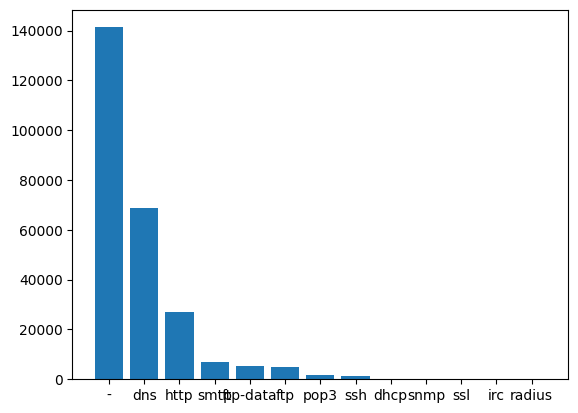

In [31]:
plt.bar(unsw['service'].value_counts().index, unsw['service'].value_counts())
plt.show()

Podemos ver que hay 13 valores únicos, y que la mayoría de los datos son "-", pero vamos a esperar que nos ofrece en cuanto a correlación antes de decidir que hacer con esta columna

Ahora, observemos la columna de protocolos

In [32]:
unsw['proto'].value_counts()

proto
tcp       123041
udp        92701
unas       15599
arp         3846
ospf        3271
           ...  
rdp          131
netblt       131
igmp          48
icmp          15
rtp            1
Name: count, Length: 133, dtype: int64

In [33]:
unsw['proto'].nunique()

133

<BarContainer object of 133 artists>

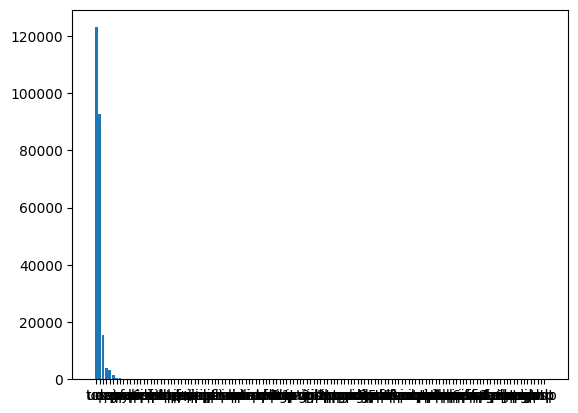

In [34]:
plt.bar(unsw['proto'].value_counts().index, unsw['proto'].value_counts())

Podemos ver que hay 133 valores únicos, por lo cual, no tiene sentido hacer un histograma, pero podemos ver que hay 3 valores que son mucho más comunes que los demás, por lo cual, vamos a ver si hay correlación con la variable target. 

<BarContainer object of 10 artists>

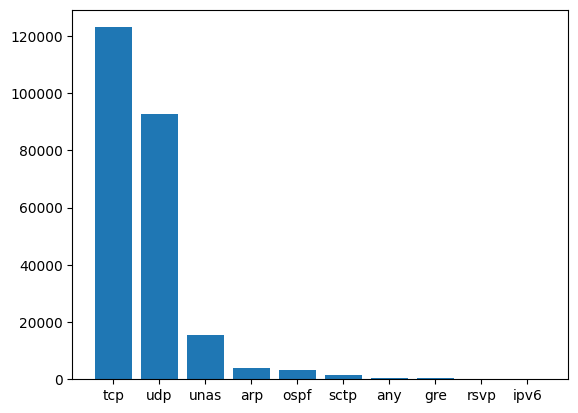

In [35]:
#bar plot con los 10 valores más comunes
plt.bar(unsw['proto'].value_counts().nlargest(10).index, unsw['proto'].value_counts().nlargest(10))

En este grafico más leible, podemos ver que los valores más comunes son tcp, udp y unas.

Ahora, observemos la columna state

In [36]:
unsw['state'].value_counts()

state
FIN    117164
INT    116438
CON     20134
REQ      3833
RST        84
ECO        12
ACC         4
PAR         1
URN         1
no          1
CLO         1
Name: count, dtype: int64

In [37]:
unsw['state'].nunique()

11

<BarContainer object of 11 artists>

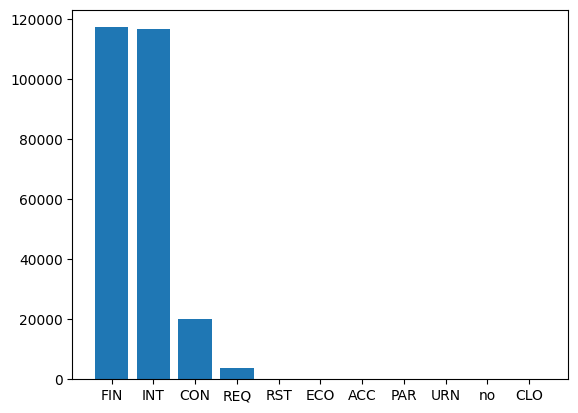

In [38]:
plt.bar(unsw['state'].value_counts().index, unsw['state'].value_counts())

Podemos ver que los estados de las conexiones del dataset son mayormente FIN: que la conexión se terminó, INT: que la conexión fue interrumpida, y CON: que la conexión fue establecida, y REQ: que la conexión fue pedida por un cliente.

Ahora, observemos la columna attack_cat

In [39]:
unsw['attack_cat'].value_counts()

attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64

In [40]:
unsw['attack_cat'].nunique()

10

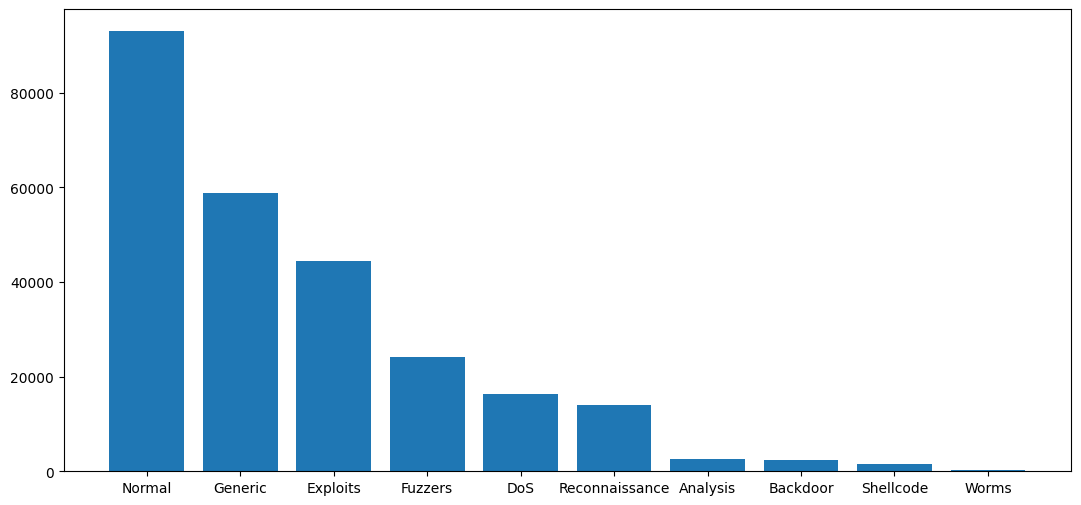

In [41]:
#ampliamos la figura para que se pudiera leer bien
plt.figure(figsize=(13, 6))
plt.bar(unsw['attack_cat'].value_counts().index, unsw['attack_cat'].value_counts())
plt.show()

Podemos ver que hay 11 categorias de ataque, a diferencia del dataset anterior, podemos ver que tenemos más datos de ataques que de no ataques.

In [42]:
#Verificamos que generic si sea un ataque
unsw[unsw['attack_cat'] == 'Generic'].head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
117204,117205,0.000003,udp,dns,INT,2,0,114,0,333333.32150,...,10,22,0,0,0,22,22,0,Generic,1
117207,117208,0.000009,udp,dns,INT,2,0,114,0,111111.10720,...,18,28,0,0,0,18,28,0,Generic,1
117208,117209,0.000009,udp,dns,INT,2,0,114,0,111111.10720,...,17,33,0,0,0,17,33,0,Generic,1
117209,117210,0.000012,udp,dns,INT,2,0,114,0,83333.33039,...,18,20,0,0,0,18,20,0,Generic,1
117211,117212,0.000010,udp,dns,INT,2,0,114,0,100000.00250,...,8,26,0,0,0,9,26,0,Generic,1


Ahora, observemos la columna label, que es nuestro target

In [43]:
unsw['label'].value_counts()

label
1    164673
0     93000
Name: count, dtype: int64

In [44]:
unsw['label'].nunique()

2

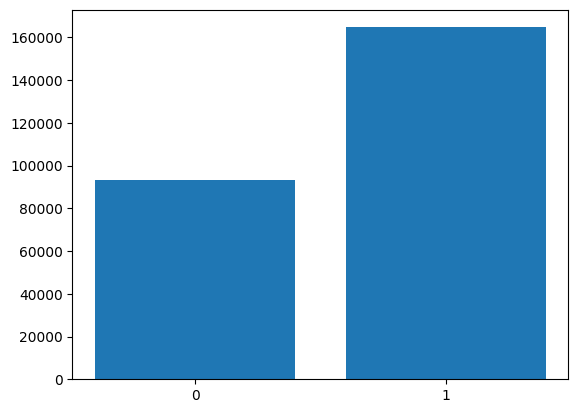

In [45]:
plt.bar(unsw['label'].value_counts().index, unsw['label'].value_counts())
plt.xticks(unsw['label'].value_counts().index, ['1','0'])
plt.show()

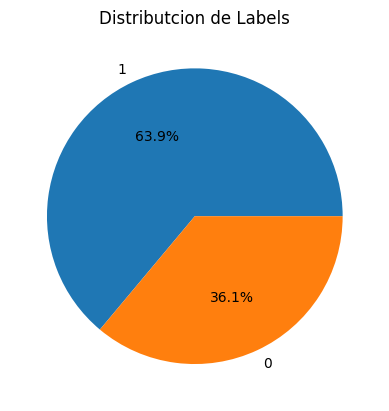

In [46]:
labels = unsw['label'].value_counts().index.tolist()
sizes = unsw['label'].value_counts().tolist()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Distributcion de Labels')
plt.show()

Podemos ver que hay 2 valores únicos, y que hay más datos de ataques que de no ataques, lo cual se podía observar en attack_cat, pero ahora lo podemos ver de manera más clara.

Antes de observar la correlacion, tenemos que transformar las columnas categoricas a numericas

In [47]:
unsw['service'] = le.fit_transform(unsw['service'])
unsw['proto'] = le.fit_transform(unsw['proto'])
unsw['state'] = le.fit_transform(unsw['state'])
#Aunque el resto no importa mucho la transformacion, ya habiamos dicho que 0 es una conexion normal, por lo cual, vamos a transformar los datos de attack_cat
unsw['attack_cat'] = unsw['attack_cat'].replace('Normal', '0')
unsw['attack_cat'] = le.fit_transform(unsw['attack_cat'])

In [48]:
print(unsw['service'].value_counts())
print(unsw['proto'].value_counts())
print(unsw['state'].value_counts())
print(unsw['attack_cat'].value_counts())


service
0     141321
2      68661
5      27011
9       6909
4       5391
3       4980
7       1528
11      1506
1        120
10       109
12        86
6         30
8         21
Name: count, dtype: int64
proto
113    123041
119     92701
120     15599
6        3846
78       3271
        ...  
89        131
75        131
42         48
37         15
91          1
Name: count, Length: 133, dtype: int64
state
4     117164
5     116438
2      20134
7       3833
8         84
3         12
0          4
6          1
9          1
10         1
1          1
Name: count, dtype: int64
attack_cat
0    93000
6    58871
4    44525
5    24246
3    16353
7    13987
1     2677
2     2329
8     1511
9      174
Name: count, dtype: int64


In [49]:
unsw.dtypes

id                     int64
dur                  float64
proto                  int32
service                int32
state                  int32
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_l

Ahora, observemos si hay valores atipicos en las columnas numericas

In [50]:
unsw.describe()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,72811.823858,1.246715,110.136025,1.555902,4.341468,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,...,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,3.184319,0.639077
std,48929.917641,5.974305,21.349900,2.245945,0.887420,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,...,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,2.628650,0.480269
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,32210.000000,0.000008,113.000000,0.000000,4.000000,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,...,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000
50%,64419.000000,0.004285,113.000000,0.000000,4.000000,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,...,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,4.000000,1.000000
75%,110923.000000,0.685777,119.000000,2.000000,5.000000,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,...,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,6.000000,1.000000
max,175341.000000,59.999989,132.000000,12.000000,10.000000,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,...,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,9.000000,1.000000


Podemos ver que todas las columnas tienen valores atipicos y que la desviación estandar es muy alta, en muchos casos, por ende vamos a usar el metodo que ya creamos para ver los valores atipicos

In [51]:
datos_atipicos(unsw,'rate')
datos_atipicos(unsw,'sttl')
datos_atipicos(unsw,'sload')
datos_atipicos(unsw,'dload')
datos_atipicos(unsw,'sinpkt')
datos_atipicos(unsw,'swin')
datos_atipicos(unsw,'stcpb')
datos_atipicos(unsw,'dtcpb')
datos_atipicos(unsw,'dwin')
datos_atipicos(unsw,'dmean')
datos_atipicos(unsw,'ct_srv_src')
datos_atipicos(unsw,'ct_state_ttl')
datos_atipicos(unsw,'ct_dst_ltm')
datos_atipicos(unsw,'ct_src_dport_ltm')
datos_atipicos(unsw,'ct_dst_sport_ltm')
datos_atipicos(unsw,'ct_dst_src_ltm')
datos_atipicos(unsw,'ct_src_ltm')
datos_atipicos(unsw,'ct_srv_dst')
datos_atipicos(unsw,'is_sm_ips_ports')

Datos atipicos en: rate
Cantidad de datos atipicos en rate inferior: 64418
Cantidad de datos atipicos en rate superior: 52841
Cantidad de datos atipicos en rate : 117259
Porcentaje de datos atipicos en rate : 45.506902158937876 % 

Datos atipicos en: sttl
Cantidad de datos atipicos en sttl inferior: 60572
Cantidad de datos atipicos en sttl superior: 38
Cantidad de datos atipicos en sttl : 60610
Porcentaje de datos atipicos en sttl : 23.522060906653007 % 

Datos atipicos en: sload
Cantidad de datos atipicos en sload inferior: 64418
Cantidad de datos atipicos en sload superior: 64322
Cantidad de datos atipicos en sload : 128740
Porcentaje de datos atipicos en sload : 49.96254943280825 % 

Datos atipicos en: dload
Cantidad de datos atipicos en dload inferior: 0
Cantidad de datos atipicos en dload superior: 64418
Cantidad de datos atipicos en dload : 64418
Porcentaje de datos atipicos en dload : 24.999902977805203 % 

Datos atipicos en: sinpkt
Cantidad de datos atipicos en sinpkt inferior:

Encontramos algo interesante, swin y dwin no tienen valores atipicos, veamos que valores unicos tienen

In [52]:
print(unsw['swin'].value_counts())

swin
0      134632
255    123021
245         1
52          1
154         1
67          1
5           1
99          1
202         1
156         1
42          1
167         1
168         1
172         1
87          1
45          1
103         1
192         1
14          1
232         1
31          1
43          1
Name: count, dtype: int64


Gracias a la documentación de UNSW_NB15, sabemos que swin y dwin son el tamaño de la ventana de envio y recepción, es normal que estos valores sean 0, por ende no debemos preocuparnos de que tengamos valores nulos o atipicos en estas columnas. 

Ahora, vamos a borrar los valores atipicos, y vamos a observar la correlación

In [53]:
unsw_limpio = borrar_atipicos(unsw,'rate')
unsw_limpio = borrar_atipicos(unsw_limpio,'sttl')
unsw_limpio = borrar_atipicos(unsw_limpio,'sload')
unsw_limpio = borrar_atipicos(unsw_limpio,'dload')
unsw_limpio = borrar_atipicos(unsw_limpio,'sinpkt')
unsw_limpio = borrar_atipicos(unsw_limpio,'stcpb')
unsw_limpio = borrar_atipicos(unsw_limpio,'dtcpb')
unsw_limpio = borrar_atipicos(unsw_limpio,'dmean')
unsw_limpio = borrar_atipicos(unsw_limpio,'ct_srv_src')
unsw_limpio = borrar_atipicos(unsw_limpio,'ct_state_ttl')
unsw_limpio = borrar_atipicos(unsw_limpio,'ct_dst_ltm')
unsw_limpio = borrar_atipicos(unsw_limpio,'ct_src_dport_ltm')
unsw_limpio = borrar_atipicos(unsw_limpio,'ct_dst_sport_ltm')
unsw_limpio = borrar_atipicos(unsw_limpio,'ct_dst_src_ltm')
unsw_limpio = borrar_atipicos(unsw_limpio,'ct_src_ltm')
unsw_limpio = borrar_atipicos(unsw_limpio,'ct_srv_dst')
unsw_limpio = borrar_atipicos(unsw_limpio,'is_sm_ips_ports')
unsw_limpio.corrwith(unsw_limpio['label']).abs().sort_values(ascending=False)

id                  NaN
dur                 NaN
proto               NaN
service             NaN
state               NaN
spkts               NaN
dpkts               NaN
sbytes              NaN
dbytes              NaN
rate                NaN
sttl                NaN
dttl                NaN
sload               NaN
dload               NaN
sloss               NaN
dloss               NaN
sinpkt              NaN
dinpkt              NaN
sjit                NaN
djit                NaN
swin                NaN
stcpb               NaN
dtcpb               NaN
dwin                NaN
tcprtt              NaN
synack              NaN
ackdat              NaN
smean               NaN
dmean               NaN
trans_depth         NaN
response_body_len   NaN
ct_srv_src          NaN
ct_state_ttl        NaN
ct_dst_ltm          NaN
ct_src_dport_ltm    NaN
ct_dst_sport_ltm    NaN
ct_dst_src_ltm      NaN
is_ftp_login        NaN
ct_ftp_cmd          NaN
ct_flw_http_mthd    NaN
ct_src_ltm          NaN
ct_srv_dst      

Tenemos el mismo problema que con el dataset anterior, borrar todos los datos atipicos, nos borra todos los datos, por lo cual, vamos a borrar los datos atípicos de una columna a la vez, empezando por la que tenian mayor correlación, para esto vamos a primero observar las correlaciones con los valores atipicos, y de ahí vamos a borrar los valores atipicos de una columna a la vez.

Ahora, que todas las columnas son numericas, podemos observar la correlación

In [54]:
unsw.corrwith(unsw['label']).abs().sort_values(ascending=False)

label                1.000000
attack_cat           0.910364
sttl                 0.624082
id                   0.490584
ct_state_ttl         0.476559
state                0.462972
ct_dst_sport_ltm     0.371672
swin                 0.364877
dload                0.352169
dwin                 0.339166
rate                 0.335883
ct_src_dport_ltm     0.318518
ct_dst_src_ltm       0.299609
dmean                0.295173
stcpb                0.266585
dtcpb                0.263543
ct_src_ltm           0.252498
ct_srv_dst           0.247812
ct_srv_src           0.246596
ct_dst_ltm           0.240776
sload                0.165249
is_sm_ips_ports      0.160126
sinpkt               0.155454
dpkts                0.097394
dloss                0.075961
service              0.073552
dbytes               0.060403
djit                 0.048819
synack               0.043250
spkts                0.043040
dinpkt               0.030136
dur                  0.029096
smean                0.028372
tcprtt    

Podemos ver que la correlación más alta es con la columna attack_cat, lo cual tiene sentido, ya que es la columna que nos dice si es un ataque o no, sin embargo, no la vamos a borrar, dado que podriamos usarla como un segundo target para el modelo intente decir que ataque es.

Otro dato interesante es id, que tiene una correlación alta, pero solo es un identificador unico de la columna, por ende lo vamos a borrar.

In [55]:
unsw = unsw.drop(columns=['id'])
unsw.corrwith(unsw['label']).abs().sort_values(ascending=False)

label                1.000000
attack_cat           0.910364
sttl                 0.624082
ct_state_ttl         0.476559
state                0.462972
ct_dst_sport_ltm     0.371672
swin                 0.364877
dload                0.352169
dwin                 0.339166
rate                 0.335883
ct_src_dport_ltm     0.318518
ct_dst_src_ltm       0.299609
dmean                0.295173
stcpb                0.266585
dtcpb                0.263543
ct_src_ltm           0.252498
ct_srv_dst           0.247812
ct_srv_src           0.246596
ct_dst_ltm           0.240776
sload                0.165249
is_sm_ips_ports      0.160126
sinpkt               0.155454
dpkts                0.097394
dloss                0.075961
service              0.073552
dbytes               0.060403
djit                 0.048819
synack               0.043250
spkts                0.043040
dinpkt               0.030136
dur                  0.029096
smean                0.028372
tcprtt               0.024668
sbytes    

Dicho esto, aun tenemos muchas columnas con poca correlacion, por ende vamos a borrar las columnas con correlacion menor a 0.1

In [56]:
columansToDrop = unsw.columns[unsw.corrwith(unsw['label']).abs() < 0.1]
unsw = unsw.drop(columns=columansToDrop)

In [57]:
unsw.corrwith(unsw['label']).abs().sort_values(ascending=False)

label               1.000000
attack_cat          0.910364
sttl                0.624082
ct_state_ttl        0.476559
state               0.462972
ct_dst_sport_ltm    0.371672
swin                0.364877
dload               0.352169
dwin                0.339166
rate                0.335883
ct_src_dport_ltm    0.318518
ct_dst_src_ltm      0.299609
dmean               0.295173
stcpb               0.266585
dtcpb               0.263543
ct_src_ltm          0.252498
ct_srv_dst          0.247812
ct_srv_src          0.246596
ct_dst_ltm          0.240776
sload               0.165249
is_sm_ips_ports     0.160126
sinpkt              0.155454
dtype: float64

Teniendo ahora las correlaciones con valores atipicos, vamos a borrar los valores atipicos de una columna a la vez, empezando por la que tenian mayor correlación

In [58]:
unsw_limpio = borrar_atipicos(unsw,'sttl')
print('Porcentaje de reducción del dataset original', 100 - (unsw_limpio.shape[0]/unsw.shape[0] * 100),'%')
unsw_limpio.corrwith(unsw_limpio['label']).abs().sort_values(ascending=False)

Porcentaje de reducción del dataset original 0.0 %


label               1.000000
attack_cat          0.910364
sttl                0.624082
ct_state_ttl        0.476559
state               0.462972
ct_dst_sport_ltm    0.371672
swin                0.364877
dload               0.352169
dwin                0.339166
rate                0.335883
ct_src_dport_ltm    0.318518
ct_dst_src_ltm      0.299609
dmean               0.295173
stcpb               0.266585
dtcpb               0.263543
ct_src_ltm          0.252498
ct_srv_dst          0.247812
ct_srv_src          0.246596
ct_dst_ltm          0.240776
sload               0.165249
is_sm_ips_ports     0.160126
sinpkt              0.155454
dtype: float64

Podemos ver que no se borran datos atipicos de esta columna, esto se debe a que estos datos estan relativamente cerca al rango intercuartil (1.5 más o menos), por lo cual, vamos a borrar los datos atipicos de la siguiente columna

In [59]:
unsw_limpio = borrar_atipicos(unsw_limpio,'ct_dst_ltm')
print('Porcentaje de reducción del dataset original', 100 - (unsw_limpio.shape[0]/unsw.shape[0] * 100),'%')
unsw_limpio.corrwith(unsw_limpio['label']).abs().sort_values(ascending=False)

Porcentaje de reducción del dataset original 16.450307172268737 %


label               1.000000
attack_cat          0.906107
sttl                0.590030
ct_state_ttl        0.450991
state               0.421029
dload               0.338617
ct_dst_sport_ltm    0.299424
rate                0.295012
swin                0.273727
dmean               0.253332
dwin                0.251502
stcpb               0.191117
dtcpb               0.187807
ct_src_dport_ltm    0.185015
sload               0.162481
is_sm_ips_ports     0.153805
sinpkt              0.146713
ct_dst_src_ltm      0.123994
ct_dst_ltm          0.069725
ct_srv_src          0.029525
ct_srv_dst          0.028493
ct_src_ltm          0.023377
dtype: float64

In [60]:
unsw_limpio = borrar_atipicos(unsw_limpio,'dload')
print('Porcentaje de reducción del dataset original', 100 - (unsw_limpio.shape[0]/unsw.shape[0] * 100),'%')
unsw_limpio.corrwith(unsw_limpio['label']).abs().sort_values(ascending=False)

Porcentaje de reducción del dataset original 34.4091154292456 %


label               1.000000
attack_cat          0.869848
sttl                0.393512
swin                0.313561
dwin                0.276636
dload               0.256146
ct_dst_sport_ltm    0.246633
state               0.245720
is_sm_ips_ports     0.233129
sinpkt              0.228445
rate                0.219055
stcpb               0.214721
dtcpb               0.212648
ct_state_ttl        0.182855
dmean               0.176808
ct_src_dport_ltm    0.154632
sload               0.093860
ct_src_ltm          0.090127
ct_dst_src_ltm      0.054567
ct_srv_dst          0.048670
ct_srv_src          0.045874
ct_dst_ltm          0.032095
dtype: float64

Algo preocupante paso, perdimos mucha correlación en todas las columnas al borrar los valores atipicos de las ultimas dos columnas, vamos a empezar de nuevo saltando estas columnas

In [61]:
unsw_limpio = borrar_atipicos(unsw,'ct_state_ttl')
print('Porcentaje de reducción del dataset original', 100 - (unsw_limpio.shape[0]/unsw.shape[0] * 100),'%')
unsw_limpio.corrwith(unsw_limpio['label']).abs().sort_values(ascending=False)

Porcentaje de reducción del dataset original 1.4603780760886877 %


label               1.000000
attack_cat          0.909613
ct_state_ttl        0.643144
sttl                0.639993
state               0.534122
ct_dst_sport_ltm    0.371007
dload               0.358636
swin                0.354421
dwin                0.354261
rate                0.349303
ct_src_dport_ltm    0.317216
ct_dst_src_ltm      0.315516
dmean               0.303395
stcpb               0.277607
dtcpb               0.274624
ct_srv_dst          0.260193
ct_srv_src          0.259997
ct_src_ltm          0.259497
ct_dst_ltm          0.249201
sload               0.167062
is_sm_ips_ports     0.162823
sinpkt              0.158906
dtype: float64

Aunque perdimos correlacion en attack_cat, recordemos que esta columna podria ser nuestro segundo target, por lo cual no nos deberia preocupar este cambio

In [62]:
unsw_limpio = borrar_atipicos(unsw_limpio,'rate')  
print('Porcentaje de reducción del dataset original', 100 - (unsw_limpio.shape[0]/unsw.shape[0] * 100),'%')
unsw_limpio.corrwith(unsw_limpio['label']).abs().sort_values(ascending=False)

Porcentaje de reducción del dataset original 10.44308095920023 %


label               1.000000
attack_cat          0.914810
ct_state_ttl        0.629456
sttl                0.628716
state               0.513721
rate                0.467173
ct_dst_sport_ltm    0.354759
dload               0.352992
swin                0.317256
dwin                0.317088
ct_src_dport_ltm    0.301707
ct_dst_src_ltm      0.295567
dmean               0.284229
stcpb               0.243875
dtcpb               0.240741
ct_src_ltm          0.237281
ct_srv_src          0.235211
ct_srv_dst          0.234720
ct_dst_ltm          0.226706
is_sm_ips_ports     0.160016
sinpkt              0.155444
sload               0.150027
dtype: float64

De nuevo, aunque rate subio de corralación, muchas otras columnas bajaron, por lo cual vamos a dejarlo así, solo borrando los valores atipicos de ct_state_ttl, que favorecieron la correalción en todo el dataset

In [63]:
unsw_limpio = borrar_atipicos(unsw,'ct_state_ttl')

Con esto, terminamos con una cantidad mucho más manejeable de columnas, y con una correlación más alta.

In [64]:
#Guardamos el dataset limpio
unsw_limpio.to_csv('DataSets/UNSW_Limpio.csv', index=False)

## EDA de KDDCup99

In [65]:
kdd = pd.read_csv('DataSets/KDDCup99.csv')

In [66]:
kdd.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,Attack Type,Is attack
0,0,tcp,http,SF,181,5450,0,0,0,0,...,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,normal,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal,0


In [67]:
kdd.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

Tenemos 44 columnas, donde 3 pueden ser nuestro target, Attack nos dice que ataque es, attack Type el tipo de ataque e Is attack es 0 si no lo es y 1 si lo es.

Observemos la distribución de los ataques

In [68]:
kdd['attack'].value_counts()

attack
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64

In [69]:
kdd['attack'].nunique()

23

<BarContainer object of 10 artists>

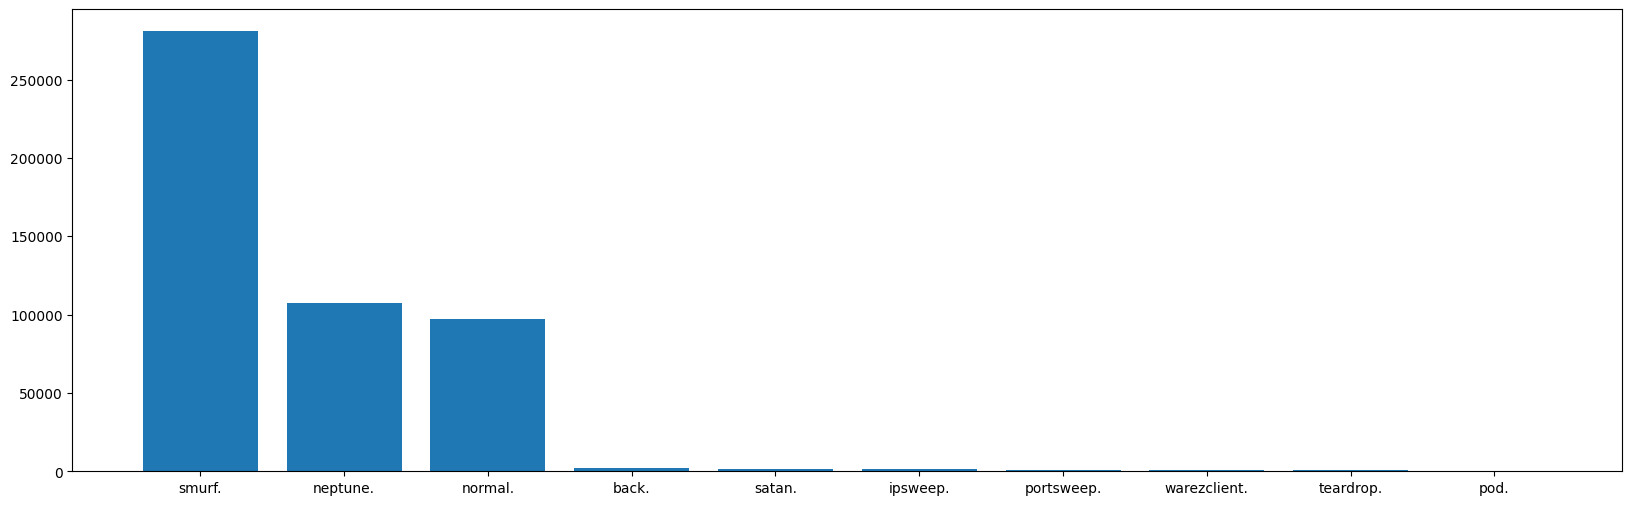

In [70]:
plt.figure(figsize=(20, 6))
plt.bar(kdd['attack'].value_counts().nlargest(10).index, kdd['attack'].value_counts().nlargest(10))

Podemos ver que hay 22 ataques, y desde ahora podemos observar que la mayoria de los datos son de ataque, por lo cual, vamos a observar la distribución de los tipos de ataques

In [71]:
kdd['Attack Type'].value_counts()

Attack Type
dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: count, dtype: int64

In [72]:
kdd['Attack Type'].nunique()

5

<BarContainer object of 5 artists>

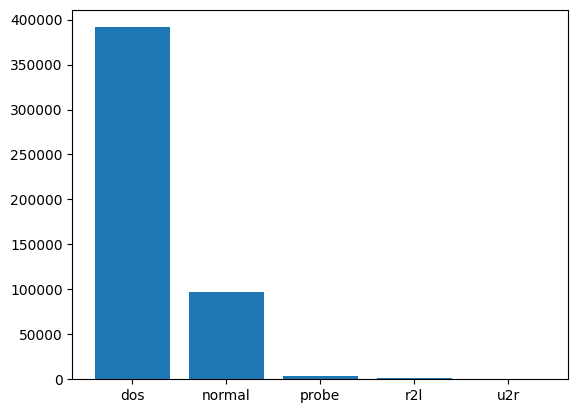

In [73]:
plt.bar(kdd['Attack Type'].value_counts().index, kdd['Attack Type'].value_counts())

Ahora, podemos ver que solo hay 4 tipos de ataques, donde la mayoria son ddos

Ahora, observemos la distribución de Is attack

In [74]:
kdd['Is attack'].value_counts()

Is attack
1    396743
0     97278
Name: count, dtype: int64

In [75]:
kdd['Is attack'].nunique()

2

([<matplotlib.axis.XTick at 0x180ac536a10>,
 [Text(1, 0, '1'), Text(0, 0, '0')])

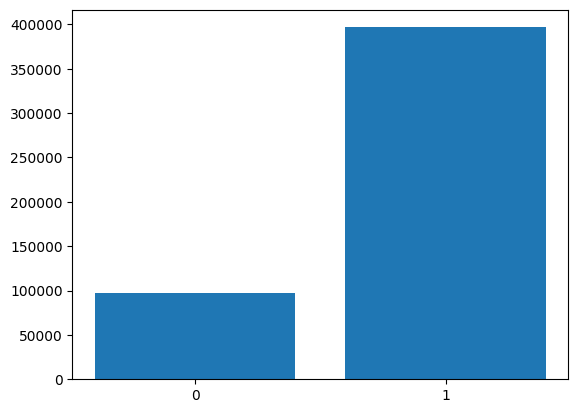

In [76]:
plt.bar(kdd['Is attack'].value_counts().index, kdd['Is attack'].value_counts())
plt.xticks(unsw['label'].value_counts().index, ['1','0'])

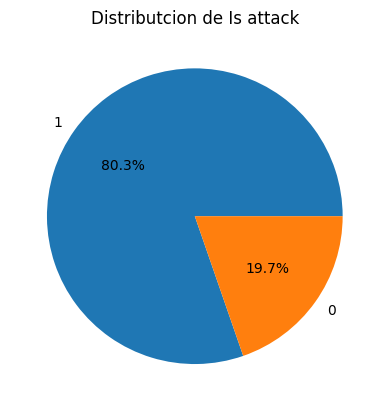

In [77]:
labels = kdd['Is attack'].value_counts().index.tolist()
sizes = kdd['Is attack'].value_counts().tolist()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Distributcion de Is attack')
plt.show()

Podemos ver que hay 2 valores únicos, y que hay más datos de ataques que de no ataques, lo cual se podía observar en attack_cat, pero ahora lo podemos ver de manera más clara. Esto podría ser un problema, ya que el modelo podría aprender a clasificar todo como ataque, por lo cual tendremos que tener cuidado con esto. En el peor de los casos, podamos usar el dataset de Kdd que incluye todos los datos para ver si tiene una mejor distribución de los datos.

Ahora observemos los datos categoricos, empezando por protocol_type

In [78]:
kdd['protocol_type'].value_counts()

protocol_type
icmp    283602
tcp     190065
udp      20354
Name: count, dtype: int64

In [79]:
kdd['protocol_type'].nunique()

3

<BarContainer object of 3 artists>

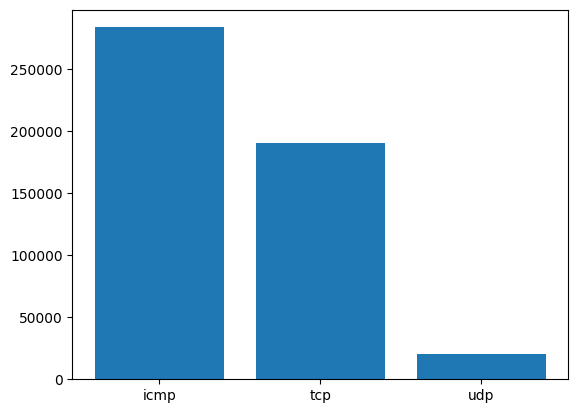

In [80]:
plt.bar(kdd['protocol_type'].value_counts().index, kdd['protocol_type'].value_counts())

Vemos que tenemos muchos menos que en unsw, sin embargo, en este caso no tenemos datos extraños. Dicho esto, podriamos tener problemas por la pequeña cantidad de categorias

Ahora, observemos la columna service

In [81]:
kdd['service'].value_counts()

service
ecr_i      281400
private    110893
http        64293
smtp         9723
other        7237
            ...  
X11            11
tim_i           7
pm_dump         1
tftp_u          1
red_i           1
Name: count, Length: 66, dtype: int64

In [82]:
kdd['service'].nunique()

66

<BarContainer object of 10 artists>

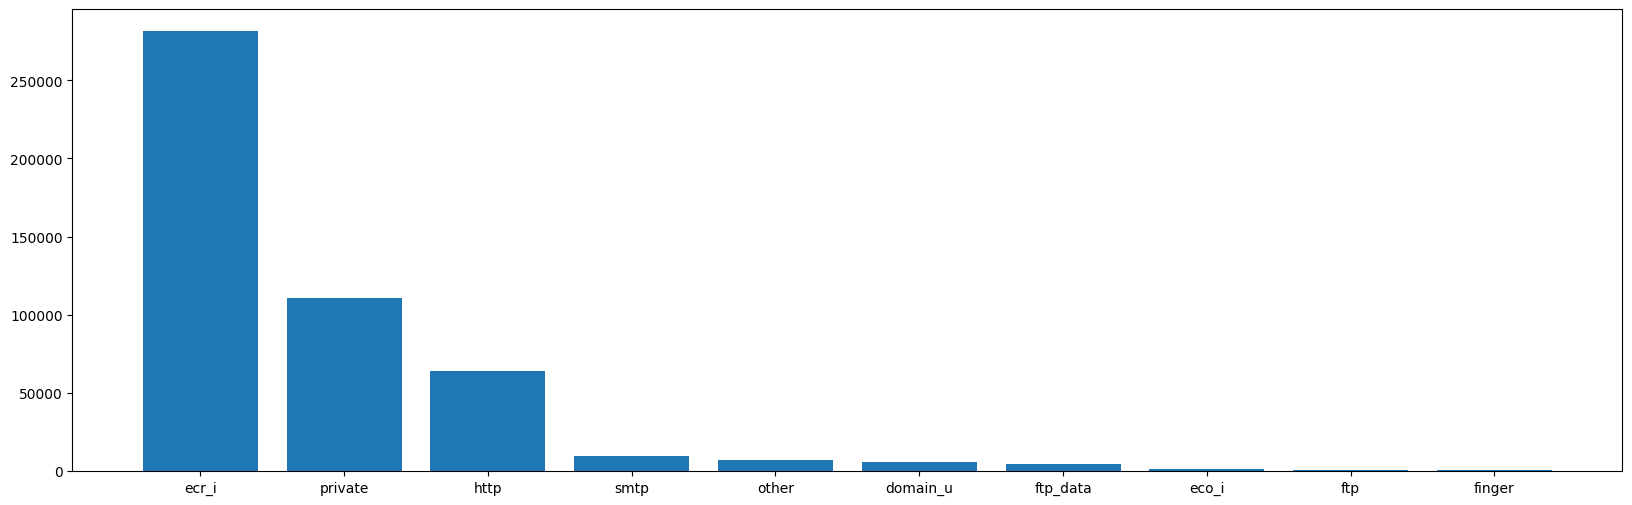

In [83]:
plt.figure(figsize=(20, 6))
plt.bar(kdd['service'].value_counts().nlargest(10).index, kdd['service'].value_counts().nlargest(10))

Ahore tenemos muchos servicios, 66 en total, donde la mayoria son erc_i, tendriamos que investigar que significa esto.

Ahora, observemos la columna flag

In [84]:
kdd['flag'].value_counts()

flag
SF        378440
S0         87007
REJ        26875
RSTR         903
RSTO         579
SH           107
S1            57
S2            24
RSTOS0        11
S3            10
OTH            8
Name: count, dtype: int64

In [85]:
kdd['flag'].nunique()

11

<BarContainer object of 11 artists>

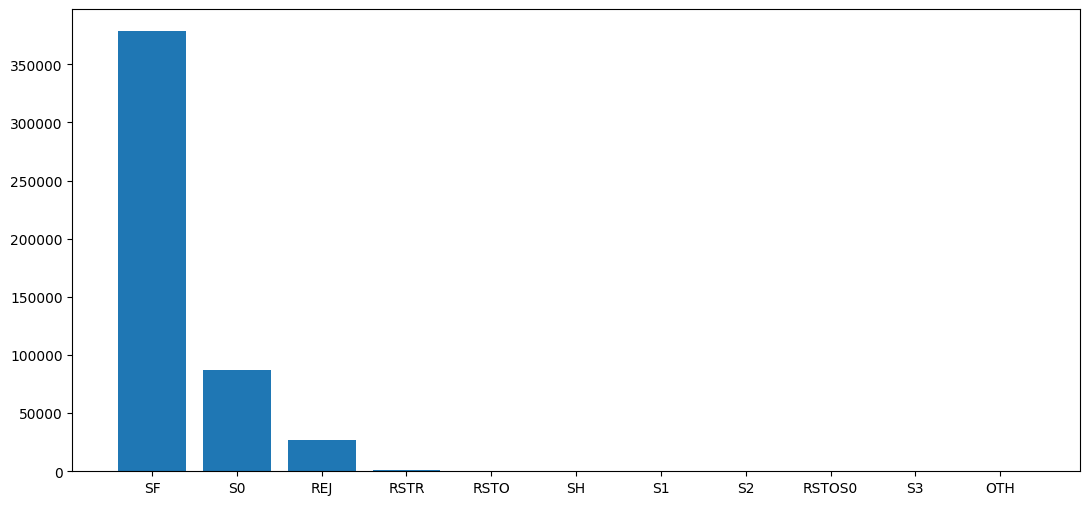

In [86]:
plt.figure(figsize=(13, 6))
plt.bar(kdd['flag'].value_counts().index, kdd['flag'].value_counts())

Podemos ver que hay 11 valores únicos, y que la mayoría son SF, que significa que la conexión fue establecida y que no hubo problemas. De nuevo, tenemos varias columnas con pocos datos

Ahora que observamos todas las columnas categoricas, vamos a observar la correlación, para esto, tenemos que usar label encoder

In [87]:
kdd['protocol_type'] = le.fit_transform(kdd['protocol_type'])
kdd['service'] = le.fit_transform(kdd['service'])
kdd['flag'] = le.fit_transform(kdd['flag'])
kdd['Attack Type'] = kdd['Attack Type'].replace('normal', '0')
kdd['Attack Type'] = le.fit_transform(kdd['Attack Type'])
kdd['attack'] = kdd['attack'].replace('normal.', '0')
kdd['attack'] = le.fit_transform(kdd['attack'])

Verificamos que los datos se hayan transformado correctamente, y que las conexiones normales sean 0

In [88]:
print(kdd['protocol_type'].unique())
print(kdd['service'].unique())
print(kdd['flag'].unique())
print(kdd['Attack Type'].unique())
print(kdd['attack'].unique())

[1 2 0]
[22 50 17 11  3 56 18 13 39 14 40 45 43 19 48 59 31 29 47 20 52 32 65 10
 30 24  8  7 38 49  0 37 23 16 44 15  5 62 26 27 12  9 55 54 25 21  6 42
 53 63 34 35 33 51 64  4  2 28 36 60  1 61 41 57 58 46]
[ 9  6  1  7  5  8  2  4  3  0 10]
[0 4 1 3 2]
[ 0  2  8 12 10 18  4 14 20 15  6  7  3  1  5 17 13 11  9 22 21 19 16]


In [89]:
kdd['attack'].head()

0    0
1    0
2    0
3    0
4    0
Name: attack, dtype: int32

In [90]:
kdd['Attack Type'].head()

0    0
1    0
2    0
3    0
4    0
Name: Attack Type, dtype: int32

Ahora, observemos la correlación

In [91]:
kdd.isna().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

Dado que tenemos 44 columnas, vamos a observar los datos atípicos de solo las columnas con correlación mayor a 0.1

In [92]:
kdd.corrwith(kdd['Is attack']).abs().sort_values(ascending=False)

C:\Users\Usuario\OneDrive\Escritorio\Cosas\Cosas de la U\Semestre 7\pdg\pdg\EDA\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Usuario\OneDrive\Escritorio\Cosas\Cosas de la U\Semestre 7\pdg\pdg\EDA\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Is attack                      1.000000
Attack Type                    0.948661
attack                         0.879475
logged_in                      0.795282
count                          0.752978
dst_host_count                 0.642110
protocol_type                  0.616601
srv_count                      0.566829
dst_host_same_src_port_rate    0.481458
srv_diff_host_rate             0.364687
same_srv_rate                  0.247405
dst_host_srv_serror_rate       0.227975
serror_rate                    0.227739
dst_host_serror_rate           0.227205
srv_serror_rate                0.227189
dst_host_srv_diff_host_rate    0.204958
flag                           0.155672
service                        0.131723
duration                       0.118014
dst_host_diff_srv_rate         0.115901
dst_host_same_srv_rate         0.109950
dst_host_srv_count             0.062566
num_access_files               0.054268
dst_bytes                      0.037709
is_guest_login                 0.032299


Podemos ver que para esta distribución del dataset num_outbound_cmds y is host login, no tienen correlación, al solo tener 1 dato unico, por lo cual vamos a borrar estas columnas

In [93]:
kdd = kdd.drop(columns=['num_outbound_cmds', 'is_host_login'])

De nuevo, no nos interesan las 3 primeras columnas, dado que son nuestras columnas "target", pero nos podrian ser utiles para posibles modelos futuros, por lo cual no las vamos a borrar.

Dicho esto, de nuevo, vamos a filtrar las columnas con correlación menor a 0.1

In [94]:
columansToDrop = kdd.columns[kdd.corrwith(kdd['Is attack']).abs() < 0.1]
kdd = kdd.drop(columns=columansToDrop)

In [95]:
kdd.corrwith(kdd['Is attack']).abs().sort_values(ascending=False)

Is attack                      1.000000
Attack Type                    0.948661
attack                         0.879475
logged_in                      0.795282
count                          0.752978
dst_host_count                 0.642110
protocol_type                  0.616601
srv_count                      0.566829
dst_host_same_src_port_rate    0.481458
srv_diff_host_rate             0.364687
same_srv_rate                  0.247405
dst_host_srv_serror_rate       0.227975
serror_rate                    0.227739
dst_host_serror_rate           0.227205
srv_serror_rate                0.227189
dst_host_srv_diff_host_rate    0.204958
flag                           0.155672
service                        0.131723
duration                       0.118014
dst_host_diff_srv_rate         0.115901
dst_host_same_srv_rate         0.109950
dtype: float64

In [96]:
kdd.describe()

,duration,protocol_type,service,flag,logged_in,count,srv_count,serror_rate,srv_serror_rate,same_srv_rate,...,dst_host_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,attack,Attack Type,Is attack
count,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,0.467132,23.408894,7.842446,0.148247,332.285690,292.906557,0.176687,0.176609,0.791547,...,232.470778,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,12.604988,0.816277,0.803089
std,707.746472,0.575606,13.538332,2.250853,0.355345,213.147412,246.322817,0.380717,0.381017,0.388189,...,64.745380,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,7.096954,0.426069,0.397665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,14.000000,9.000000,0.000000,117.000000,10.000000,0.000000,0.000000,1.000000,...,255.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,1.000000
50%,0.000000,0.000000,14.000000,9.000000,0.000000,510.000000,510.000000,0.000000,0.000000,1.000000,...,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,18.000000,1.000000,1.000000
75%,0.000000,1.000000,42.000000,9.000000,0.000000,511.000000,511.000000,0.000000,0.000000,1.000000,...,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,18.000000,1.000000,1.000000
max,58329.000000,2.000000,65.000000,10.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,22.000000,4.000000,1.000000


Parece que no tenemos datos atipicos, dado que la mayoría de las columnas son categoricas usando label encoding, o son binaria, así que dejaremos el dataset así.

Con esto, terminamos el EDA de este dataset

In [97]:
kdd.to_csv('DataSets/KDDCup99_Limpio.csv', index=False)


## EDA CICIDS2017

In [98]:
cic = pd.read_csv('DataSets/CIC-IDS2017.csv')

In [99]:
cic.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [100]:
cic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564355 entries, 0 to 1564354
Data columns (total 79 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0    Destination Port             1564355 non-null  int64  
 1    Flow Duration                1564355 non-null  int64  
 2    Total Fwd Packets            1564355 non-null  int64  
 3    Total Backward Packets       1564355 non-null  int64  
 4   Total Length of Fwd Packets   1564355 non-null  int64  
 5    Total Length of Bwd Packets  1564355 non-null  int64  
 6    Fwd Packet Length Max        1564355 non-null  int64  
 7    Fwd Packet Length Min        1564355 non-null  int64  
 8    Fwd Packet Length Mean       1564355 non-null  float64
 9    Fwd Packet Length Std        1564355 non-null  float64
 10  Bwd Packet Length Max         1564355 non-null  int64  
 11   Bwd Packet Length Min        1564355 non-null  int64  
 12   Bwd Packet Length Mean     

Afortunadamente, podemos ver que solo tenemos una columna de tipo object, por lo cual no tendremos que hacer mucho label encoding, pero antes de hacer esto, vamos a observar la distribución de los ataques

In [101]:
#dado que label tiene un extra, vamos a quitarlo
cic=cic.rename(columns = {' Label': 'Label'})

In [102]:
cic['Label'].value_counts()

Label
BENIGN                        1021667
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

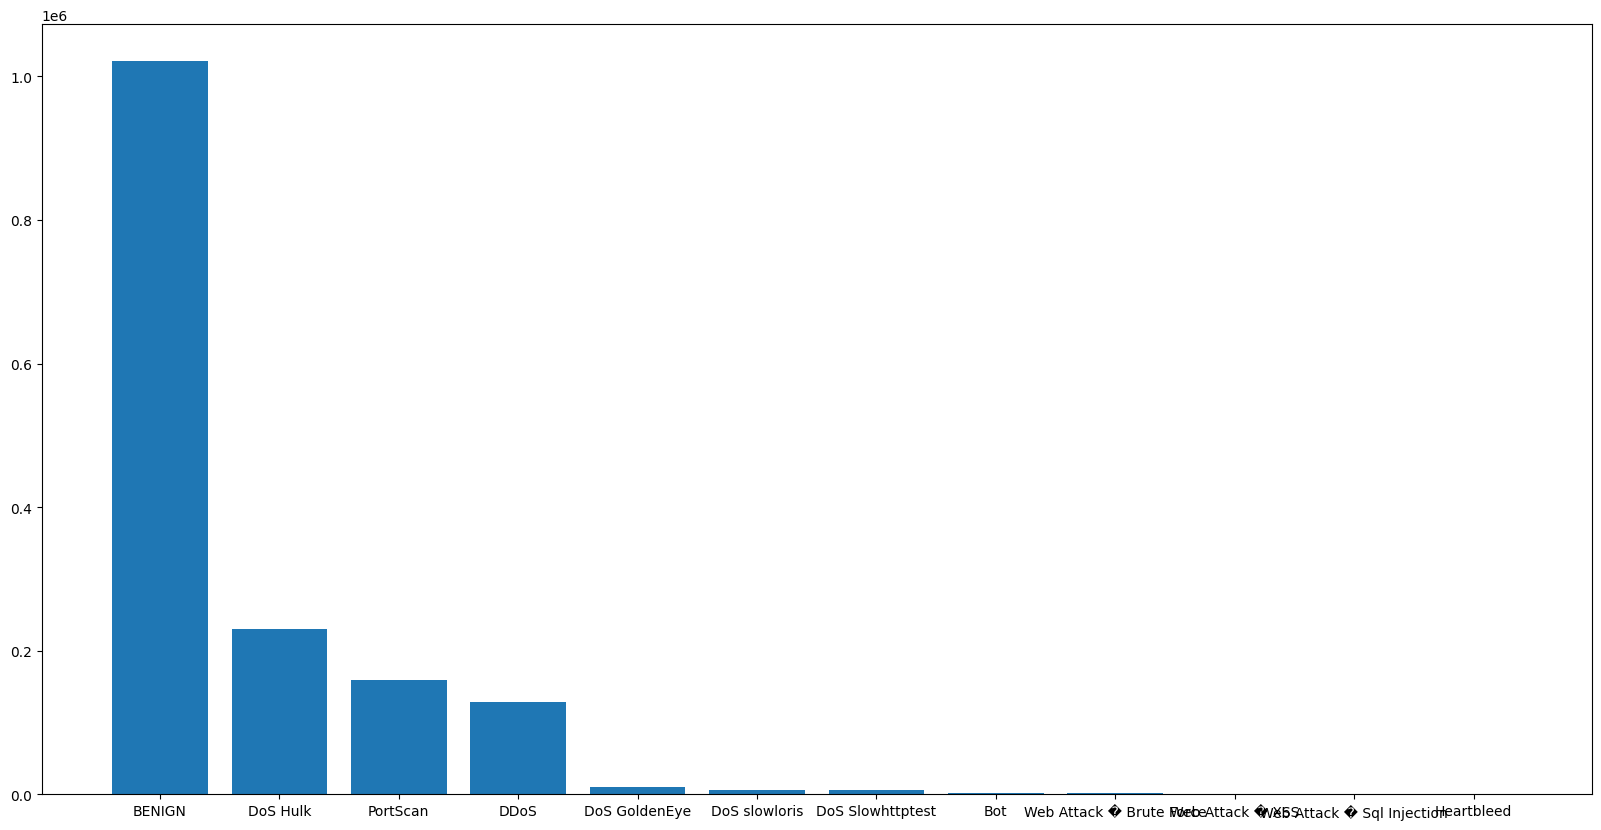

In [103]:
#box plot
plt.figure(figsize=(20, 10))
plt.bar(cic['Label'].value_counts().index, cic['Label'].value_counts())
plt.show()

Dado que tenemos muchos datos benignos, no se puede observar muy bien la distribución de los ataques

In [104]:
cic.shape

(1564355, 79)

Podemos ver que de los 1565239 datos 1022413 son benignos, es decir tenemos 542826 datos de ataques

Dicho esto, nuestros modelos sin binarios hasta el momento, asi que vamos a transformar la columna label a binaria

In [105]:
cic['Label'] = cic['Label'].map({'BENIGN': 0, 'DDoS': 1, 'PortScan': 1, 'Bot': 1, 'Infiltration': 1, 'Web Attack � Brute Force': 1, 'Web Attack � XSS': 1, 'Web Attack � Sql Injection': 1, 'FTP-Patator': 1, 'SSH-Patator': 1, 'DoS slowloris': 1, 'DoS Slowhttptest': 1, 'DoS Hulk': 1, 'DoS GoldenEye': 1, 'Heartbleed': 1})

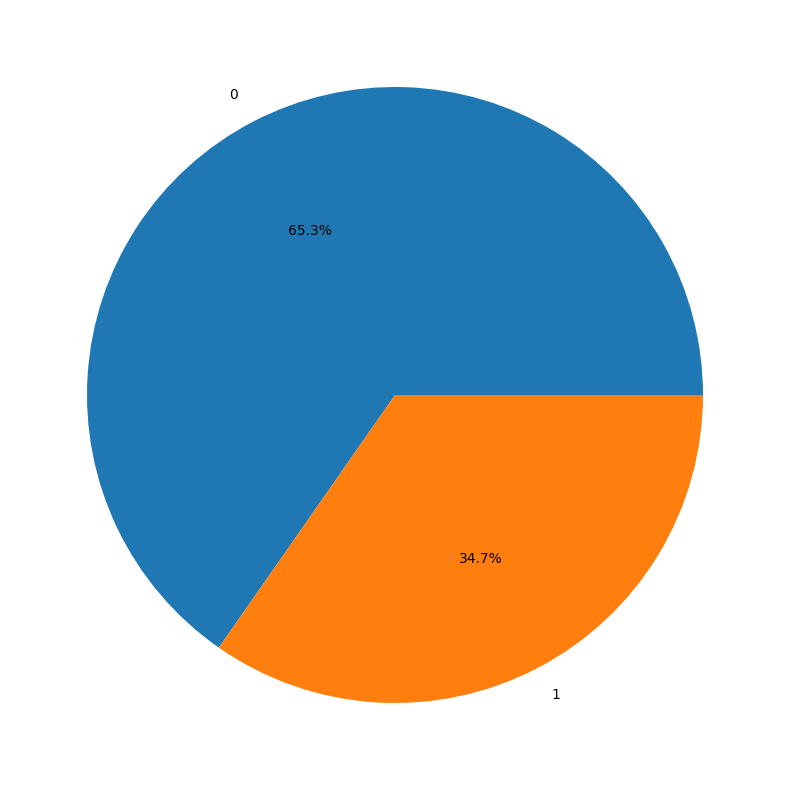

In [106]:
plt.figure(figsize=(20, 10))
plt.pie(cic['Label'].value_counts(), labels=['0','1'], autopct='%1.1f%%')
plt.show()

Aquí podemos observar mejor que el 34% de nuestros datos son ataques

Ahora, dado que no hay más datos categoricos, vamos a observar la correlación

In [107]:
cic.corrwith(cic['Label']).abs().sort_values(ascending=False)

C:\Users\Usuario\OneDrive\Escritorio\Cosas\Cosas de la U\Semestre 7\pdg\pdg\EDA\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Usuario\OneDrive\Escritorio\Cosas\Cosas de la U\Semestre 7\pdg\pdg\EDA\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Label                      1.000000
 Bwd Packet Length Std     0.492774
Bwd Packet Length Max      0.482429
 Bwd Packet Length Mean    0.482407
 Avg Bwd Segment Size      0.482407
                             ...   
 Fwd Avg Packets/Bulk           NaN
 Fwd Avg Bulk Rate              NaN
 Bwd Avg Bytes/Bulk             NaN
 Bwd Avg Packets/Bulk           NaN
Bwd Avg Bulk Rate               NaN
Length: 79, dtype: float64

Podemos ver que tenemos algunas columnas cuya correlación es NAN, vamos a observar que pasa

In [108]:
cic[' Fwd URG Flags'].value_counts()

 Fwd URG Flags
0    1564355
Name: count, dtype: int64

Podemos ver que esta columna tiene solo un valor, por lo cual no tiene sentido tenerla, por lo cual la vamos a borrar

Además, de nuevo tenemos el problema de que varias columnas empiezan con un espacio, por lo cual vamos a borrar los espacios

In [109]:
cic.columns = cic.columns.str.strip()
cic['Fwd URG Flags'].value_counts()

Fwd URG Flags
0    1564355
Name: count, dtype: int64

Con los espacios borrados, vamos a borrar las columnas con correlación NAN

In [110]:
cic = cic.drop(columns=['Fwd URG Flags','Bwd PSH Flags','Bwd URG Flags','CWE Flag Count','Fwd Avg Bytes/Bulk','Fwd Avg Packets/Bulk','Fwd Avg Bulk Rate','Bwd Avg Bytes/Bulk','Bwd Avg Packets/Bulk','Bwd Avg Bulk Rate'])

In [111]:
cic.corrwith(cic['Label']).abs().sort_values(ascending=False)

Label                          1.000000
Bwd Packet Length Std          0.492774
Bwd Packet Length Max          0.482429
Bwd Packet Length Mean         0.482407
Avg Bwd Segment Size           0.482407
                                 ...   
Fwd Header Length.1            0.004913
act_data_pkt_fwd               0.004840
Total Length of Bwd Packets    0.003459
Subflow Bwd Bytes              0.003459
Bwd IAT Mean                   0.003050
Length: 69, dtype: float64

Ahora, con el dataset limpio, vamos a borrar las columnas con correlación menor a 0.1, para no usar tanta memoria

In [112]:
columnsToDrop = cic.columns[cic.corrwith(cic['Label']).abs() < 0.1]
cic = cic.drop(columns=columnsToDrop)
cic.corrwith(cic['Label']).abs().sort_values(ascending=False)

Label                      1.000000
Bwd Packet Length Std      0.492774
Bwd Packet Length Max      0.482429
Bwd Packet Length Mean     0.482407
Avg Bwd Segment Size       0.482407
Packet Length Std          0.447065
Max Packet Length          0.434751
Packet Length Variance     0.417459
Packet Length Mean         0.411144
Average Packet Size        0.406152
Fwd IAT Std                0.399005
Min Packet Length          0.384581
Idle Max                   0.384122
Idle Mean                  0.381027
Fwd IAT Max                0.380606
Flow IAT Max               0.380544
Bwd Packet Length Min      0.373667
Idle Min                   0.371569
Flow IAT Std               0.346920
PSH Flag Count             0.236398
Fwd IAT Total              0.230396
Flow Duration              0.227783
Flow IAT Mean              0.215438
URG Flag Count             0.208861
FIN Flag Count             0.208606
Destination Port           0.186993
Fwd IAT Mean               0.183772
Fwd Packet Length Min      0

Con esto, vamos a observar si hay valores atipicos en los datos con mayor correlación

In [113]:
datos_atipicos(cic,'Bwd Packet Length Std')

Datos atipicos en: Bwd Packet Length Std
Cantidad de datos atipicos en Bwd Packet Length Std inferior: 0
Cantidad de datos atipicos en Bwd Packet Length Std superior: 391089
Cantidad de datos atipicos en Bwd Packet Length Std : 391089
Porcentaje de datos atipicos en Bwd Packet Length Std : 25.000015981027325 % 


Dado que tenemos muchos valores atipicos, vamos a ver como afecta a la correlación si los borramos

In [114]:
ciclimpio = borrar_atipicos(cic,'Bwd Packet Length Std')


In [115]:
ciclimpio.corrwith(ciclimpio['Label']).abs().sort_values(ascending=False)

Label                      1.000000
PSH Flag Count             0.312517
Min Packet Length          0.309552
Bwd Packet Length Min      0.303066
Average Packet Size        0.266777
Bwd Packet Length Mean     0.257313
Avg Bwd Segment Size       0.257313
min_seg_size_forward       0.257250
Packet Length Mean         0.254415
Bwd Packet Length Max      0.222882
Bwd Packet Length Std      0.201370
Packet Length Std          0.201067
Max Packet Length          0.196819
URG Flag Count             0.167589
Avg Fwd Segment Size       0.136746
Fwd Packet Length Mean     0.136746
Fwd Packet Length Max      0.126989
Flow Duration              0.120015
Fwd Packet Length Min      0.117905
Fwd IAT Total              0.115027
Destination Port           0.106070
ACK Flag Count             0.096916
SYN Flag Count             0.094826
Fwd PSH Flags              0.094826
Init_Win_bytes_backward    0.090410
Bwd IAT Max                0.089993
Packet Length Variance     0.089825
Bwd IAT Std                0

Podemos ver que afecto la correlación de manera negativa, lo que nos dice que valores atipicos en Bwd Packet Length Std, son importantes para el model e indican posibles ataques, asi que vamos a dejarlo así

Sin embargo, vamos a observar los valores atipicos de otras columnas a ver que pasa

In [116]:
cic.corrwith(cic['Label']).abs().sort_values(ascending=False)

Label                      1.000000
Bwd Packet Length Std      0.492774
Bwd Packet Length Max      0.482429
Bwd Packet Length Mean     0.482407
Avg Bwd Segment Size       0.482407
Packet Length Std          0.447065
Max Packet Length          0.434751
Packet Length Variance     0.417459
Packet Length Mean         0.411144
Average Packet Size        0.406152
Fwd IAT Std                0.399005
Min Packet Length          0.384581
Idle Max                   0.384122
Idle Mean                  0.381027
Fwd IAT Max                0.380606
Flow IAT Max               0.380544
Bwd Packet Length Min      0.373667
Idle Min                   0.371569
Flow IAT Std               0.346920
PSH Flag Count             0.236398
Fwd IAT Total              0.230396
Flow Duration              0.227783
Flow IAT Mean              0.215438
URG Flag Count             0.208861
FIN Flag Count             0.208606
Destination Port           0.186993
Fwd IAT Mean               0.183772
Fwd Packet Length Min      0

In [117]:
ciclimpio= borrar_atipicos(cic,'Bwd Packet Length Std')
ciclimpio= borrar_atipicos(ciclimpio,'Bwd Packet Length Max')

In [118]:
ciclimpio.corrwith(ciclimpio['Label']).abs().sort_values(ascending=False)

Label                      1.000000
PSH Flag Count             0.567127
Avg Bwd Segment Size       0.435067
Bwd Packet Length Mean     0.435067
Bwd Packet Length Max      0.433186
Bwd Packet Length Min      0.422754
Min Packet Length          0.410051
min_seg_size_forward       0.257496
Average Packet Size        0.228378
Packet Length Mean         0.212789
URG Flag Count             0.205789
Fwd Packet Length Min      0.149309
Destination Port           0.148594
Avg Fwd Segment Size       0.127985
Fwd Packet Length Mean     0.127985
Fwd PSH Flags              0.115428
SYN Flag Count             0.115428
Packet Length Std          0.115113
Max Packet Length          0.109973
Bwd Packet Length Std      0.091866
Fwd Packet Length Max      0.091724
Init_Win_bytes_backward    0.087569
Packet Length Variance     0.063245
Bwd IAT Max                0.052353
ACK Flag Count             0.043420
Flow IAT Mean              0.038607
FIN Flag Count             0.027216
Bwd IAT Std                0

Podemos ver que borrar los valores atipicos de bwd packet length max y std, afecto la correlación de manera negativa, dado que aunque sube la correlación de PSH Flag count, reduce el resto

In [119]:
ciclimpio= borrar_atipicos(cic,'Average Packet Size')

In [120]:
ciclimpio.corrwith(ciclimpio['Label']).abs().sort_values(ascending=False)

Label                      1.000000
Min Packet Length          0.382172
Average Packet Size        0.369219
Bwd Packet Length Min      0.343527
Packet Length Mean         0.339532
PSH Flag Count             0.337933
Bwd Packet Length Mean     0.293533
Avg Bwd Segment Size       0.293533
min_seg_size_forward       0.257071
Packet Length Std          0.228229
Max Packet Length          0.217593
Bwd Packet Length Max      0.213575
Fwd Packet Length Mean     0.213020
Avg Fwd Segment Size       0.213020
Fwd Packet Length Max      0.176511
Bwd Packet Length Std      0.167734
URG Flag Count             0.167015
Fwd Packet Length Min      0.145112
Packet Length Variance     0.137032
Flow Duration              0.100878
ACK Flag Count             0.099206
SYN Flag Count             0.096697
Fwd PSH Flags              0.096697
Fwd IAT Total              0.096278
Destination Port           0.093920
Init_Win_bytes_backward    0.092367
Bwd IAT Max                0.067110
Bwd IAT Std                0

Despues de borrar valores atipicos y ver como afectaban la correlación, hemos decidido dejar el dataset como esta, dado que borrar valores atipicos afecta la correlación de manera negativa, y que los valores atipicos son importantes para el modelo

Con esto, terminamos el EDA de este dataset

In [121]:
#salvamos el df a un csv
ciclimpio.to_csv('DataSets/CICIDS2017_Limpio.csv', index=False)